#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
sp500 = pd.read_csv("/workspaces/codespaces-jupyter/data/SP500_2006_16_data.csv")
sp500# sp500 = pd.read_csv("https://osf.io/h64z2/download")

,DATE,VALUE
0,2006-08-25,1295.09
1,2006-08-28,1301.78
2,2006-08-29,1304.28
3,2006-08-30,1304.27
4,2006-08-31,1303.82
...,...,...
2606,2016-08-22,2182.64
2607,2016-08-23,2186.90
2608,2016-08-24,2175.44
2609,2016-08-25,2172.47


In [4]:
sp500 = sp500.replace("", np.nan).replace("#N/A", np.nan).dropna().reset_index(drop=True)

Create percent return

In [5]:
#Fractional change between the current and a prior element. Examples below
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

In [6]:
#Fractial change in action
s = pd.Series([90, 91, None, 85])
s.ffill().pct_change()

0         NaN
1    0.011111
2    0.000000
3   -0.065934
dtype: float64

Create date variables (we dont use these though)

In [7]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

In [52]:
sp500

,DATE,VALUE,pct_return,year,month,yearmonth
0,2006-08-25,1295.09,NaN,2006,8,200608
1,2006-08-28,1301.78,0.516566,2006,8,200608
2,2006-08-29,1304.28,0.192045,2006,8,200608
3,2006-08-30,1304.27,-0.000767,2006,8,200608
4,2006-08-31,1303.82,-0.034502,2006,8,200608
...,...,...,...,...,...,...
2514,2016-08-22,2182.64,-0.056322,2016,8,201608
2515,2016-08-23,2186.90,0.195176,2016,8,201608
2516,2016-08-24,2175.44,-0.524029,2016,8,201608
2517,2016-08-25,2172.47,-0.136524,2016,8,201608


In [111]:
sp500["pct_return"].describe()

count    2518.000000
mean        0.029145
std         1.315438
min        -9.034980
25%        -0.453734
50%         0.070897
75%         0.582782
max        11.580036
Name: pct_return, dtype: float64

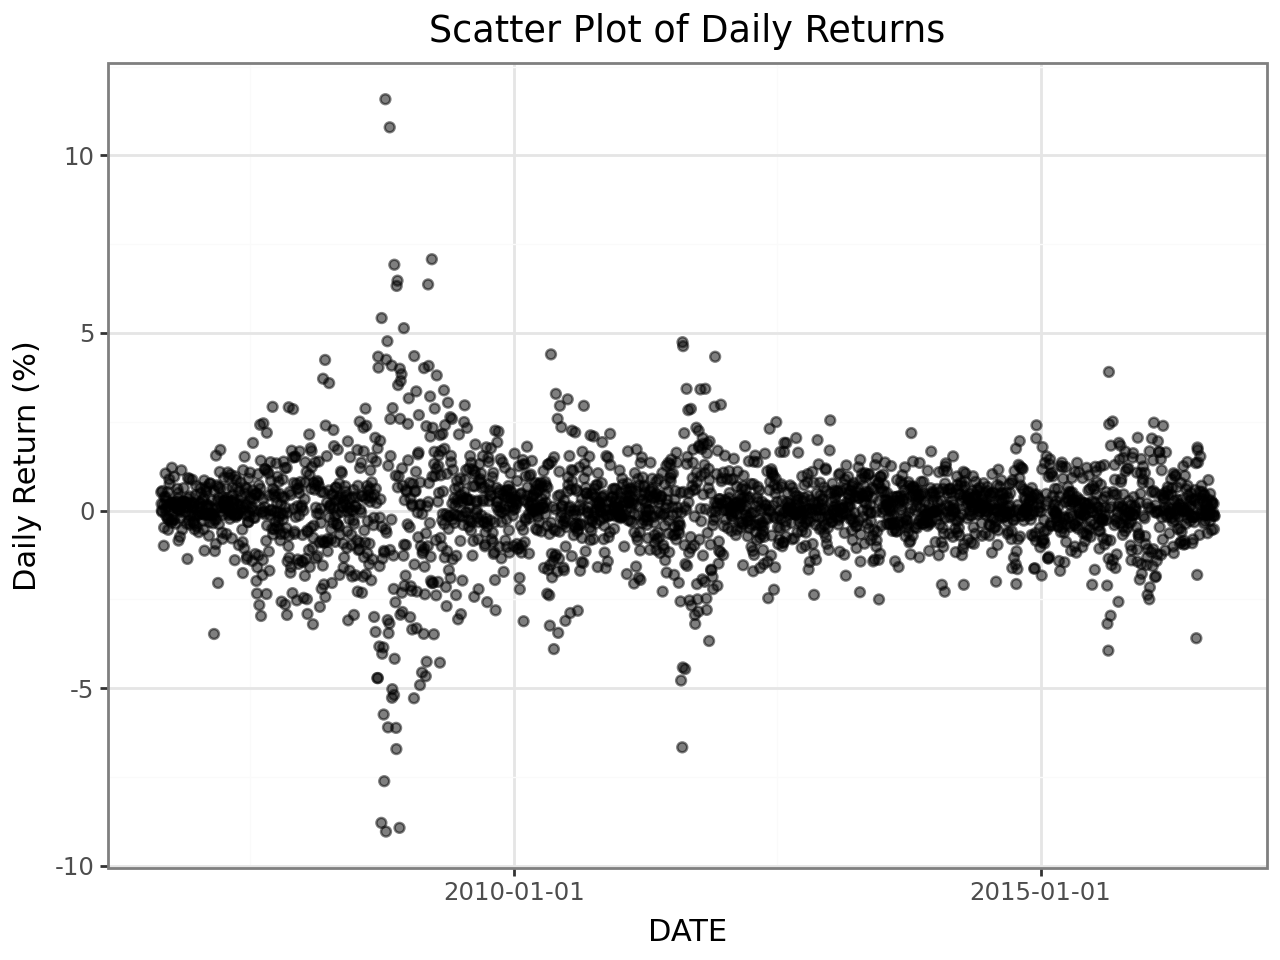

In [108]:
(
    ggplot(sp500, aes(x="DATE", y="pct_return"))
    + geom_point(alpha=0.5)
    + labs(x="DATE", y="Daily Return (%)", title="Scatter Plot of Daily Returns")
    + theme_bw()
)


### Figure 5.1 Histogram of daily returns in the entire data

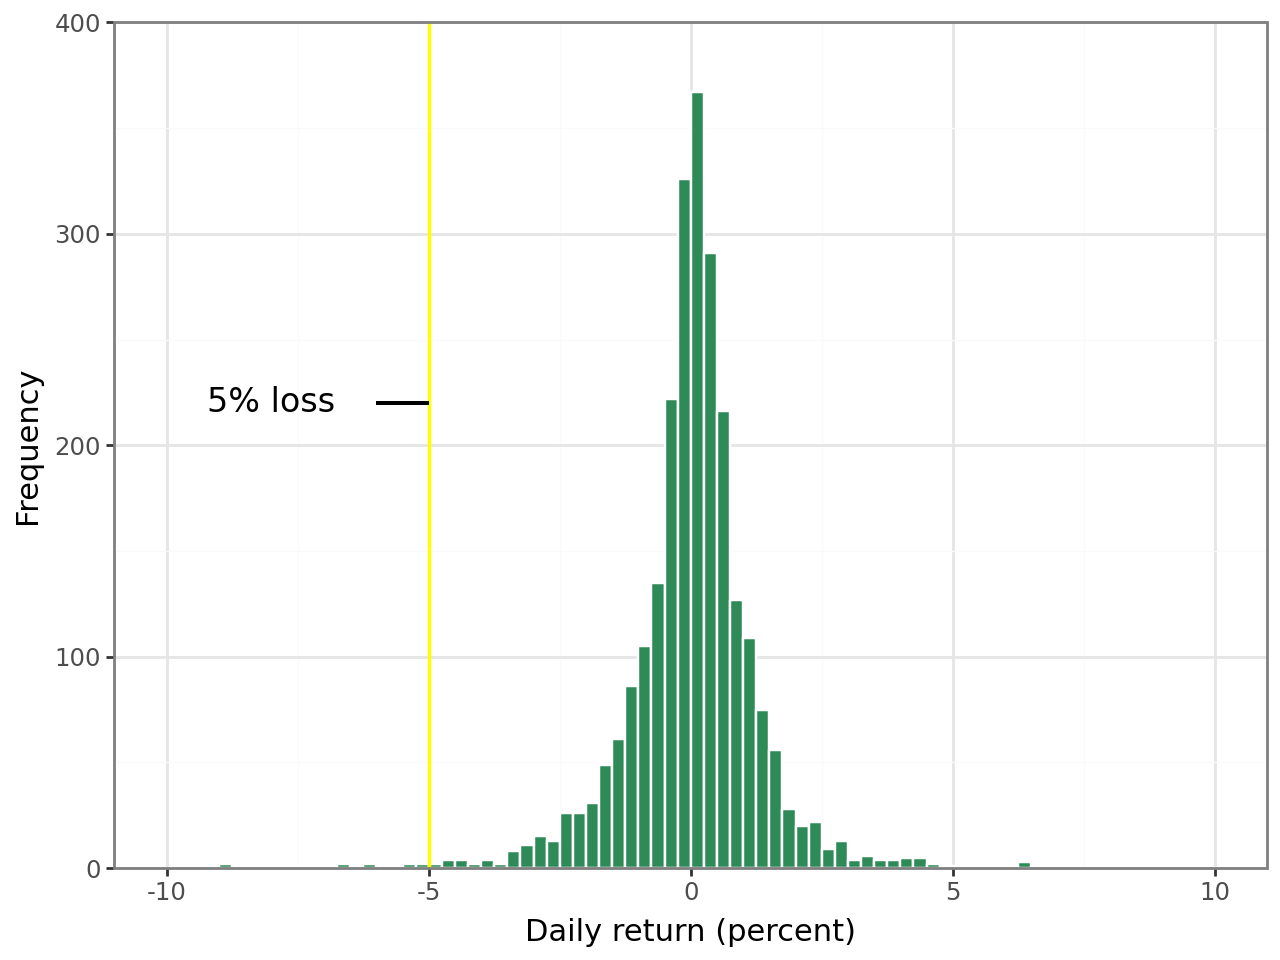

In [8]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill="seagreen", boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color="yellow")
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


In [9]:
sp500["pct_return"].describe()

count    2518.000000
mean        0.029145
std         1.315438
min        -9.034980
25%        -0.453734
50%         0.070897
75%         0.582782
max        11.580036
Name: pct_return, dtype: float64

In [10]:
sp500max=sp500.loc[sp500["pct_return"].idxmax()]
sp500max

DATE          2008-10-13 00:00:00
VALUE                     1003.35
pct_return              11.580036
year                         2008
month                          10
yearmonth                  200810
Name: 536, dtype: object

In [11]:
sp500.count()
sp500
sp500less5 = sp500.loc[sp500["pct_return"] < -5].reset_index(drop=True)
sp500less5["pct_return_decimal"] = sp500less5["pct_return"] / 100
sp500less5

,DATE,VALUE,pct_return,year,month,yearmonth,pct_return_decimal
0,2008-09-29,1106.39,-8.789705,2008,9,200809,-0.087897
1,2008-10-07,996.23,-5.739481,2008,10,200810,-0.057395
2,2008-10-09,909.92,-7.616708,2008,10,200810,-0.076167
3,2008-10-15,907.84,-9.034980,2008,10,200810,-0.090350
4,2008-10-22,896.78,-6.101251,2008,10,200810,-0.061013
5,2008-11-05,952.77,-5.267711,2008,11,200811,-0.052677
6,2008-11-06,904.88,-5.026397,2008,11,200811,-0.050264
7,2008-11-12,852.30,-5.189388,2008,11,200811,-0.051894
8,2008-11-19,806.58,-6.115560,2008,11,200811,-0.061156
9,2008-11-20,752.44,-6.712291,2008,11,200811,-0.067123


In [12]:
sp500less5['DATE'].min(), sp500less5['DATE'].max()

(Timestamp('2008-09-29 00:00:00'), Timestamp('2011-08-08 00:00:00'))

In [13]:
sp500less5["pct_return"].mean()

np.float64(-6.65138836502497)

In [14]:
true_share = (sp500["pct_return"] <= -5).mean()
print(true_share)

0.005160778086542279


### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [16]:
n_samples = 10000  # Define the number of samples

# For n=1000
samples_1000 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 1000), replace=True)
a=samples_1000 < -5

nobs_1000 = np.mean(samples_1000 < -5, axis=1)

# For n=500
samples_500 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 500), replace=True)
nobs_500 = np.mean(samples_500 < -5, axis=1)


In [17]:
a = pd.DataFrame(a)
a

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000})*100

In [19]:
a = pd.DataFrame(samples_1000).T
a

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.550735,0.717441,0.166512,0.085326,0.756733,0.638441,0.271162,-1.025153,-1.272030,-0.319285,...,1.343924,4.349122,-1.874310,-1.175928,-0.685527,-0.405528,-0.418697,0.167222,0.082400,-1.349560
1,0.432171,0.425188,-0.413540,0.110574,-1.723346,0.266971,-0.361248,1.445421,-0.183696,0.381994,...,-0.361248,-0.092894,-0.001491,-0.403968,-0.447365,0.484354,0.236225,-1.059788,-0.210985,0.832585
2,0.137639,-0.296614,-0.032161,0.450414,-0.298546,-1.205068,0.964893,0.074950,-0.036442,-0.190007,...,-0.111407,1.751488,0.090787,-1.887093,-0.164659,-2.356442,-0.197775,0.369848,0.161007,0.113021
3,1.030010,-0.834122,0.173915,-0.014332,0.205942,-0.126679,-0.470105,0.026339,-0.282798,2.144220,...,1.013908,-1.512607,-0.656101,-0.385679,-0.424219,0.577213,0.265587,-1.811375,0.247780,-0.037227
4,-0.252216,0.979669,-0.413112,0.619987,0.669110,-2.575964,0.623014,0.420113,0.016048,0.275874,...,0.525616,-1.848130,0.084439,0.254034,-0.216555,-2.428724,-0.371741,4.010332,0.371268,-0.385679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.371268,-0.415604,-0.147879,-0.056322,1.526977,-0.223388,0.002168,0.278661,-0.141700,-0.968545,...,0.211095,0.187212,-0.648991,0.959050,1.342345,-0.368717,-0.104510,-0.187119,-0.032161,3.429147
996,-2.689492,-0.968545,1.583398,1.223750,-0.325796,1.541890,-1.169385,0.953470,-0.208100,0.187279,...,-0.618435,-1.353204,-1.192557,-1.068172,-0.488862,0.254842,0.197969,1.667194,-0.179301,-0.210985
997,-0.282180,-1.101782,-0.604931,0.045218,1.102566,0.527796,0.137639,-0.013246,-0.179301,1.141657,...,0.717428,1.740429,1.113064,-0.222958,-0.151998,0.355289,0.584346,-0.153445,-1.968355,0.057490
998,0.354723,-0.471630,0.074950,-0.517661,-1.532958,-1.350648,0.441640,0.002846,0.279298,1.059274,...,-0.408965,-0.670226,2.476021,-2.159909,-1.083841,0.020516,-0.941132,-0.129493,-2.277616,0.638441


In [20]:
nobs_df

,nobs_500,nobs_1000
0,0.4,0.5
1,0.6,0.4
2,0.8,0.6
3,1.0,1.3
4,0.4,0.1
...,...,...
9995,0.2,0.4
9996,0.2,0.2
9997,0.2,0.7
9998,0.6,0.2


In [21]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

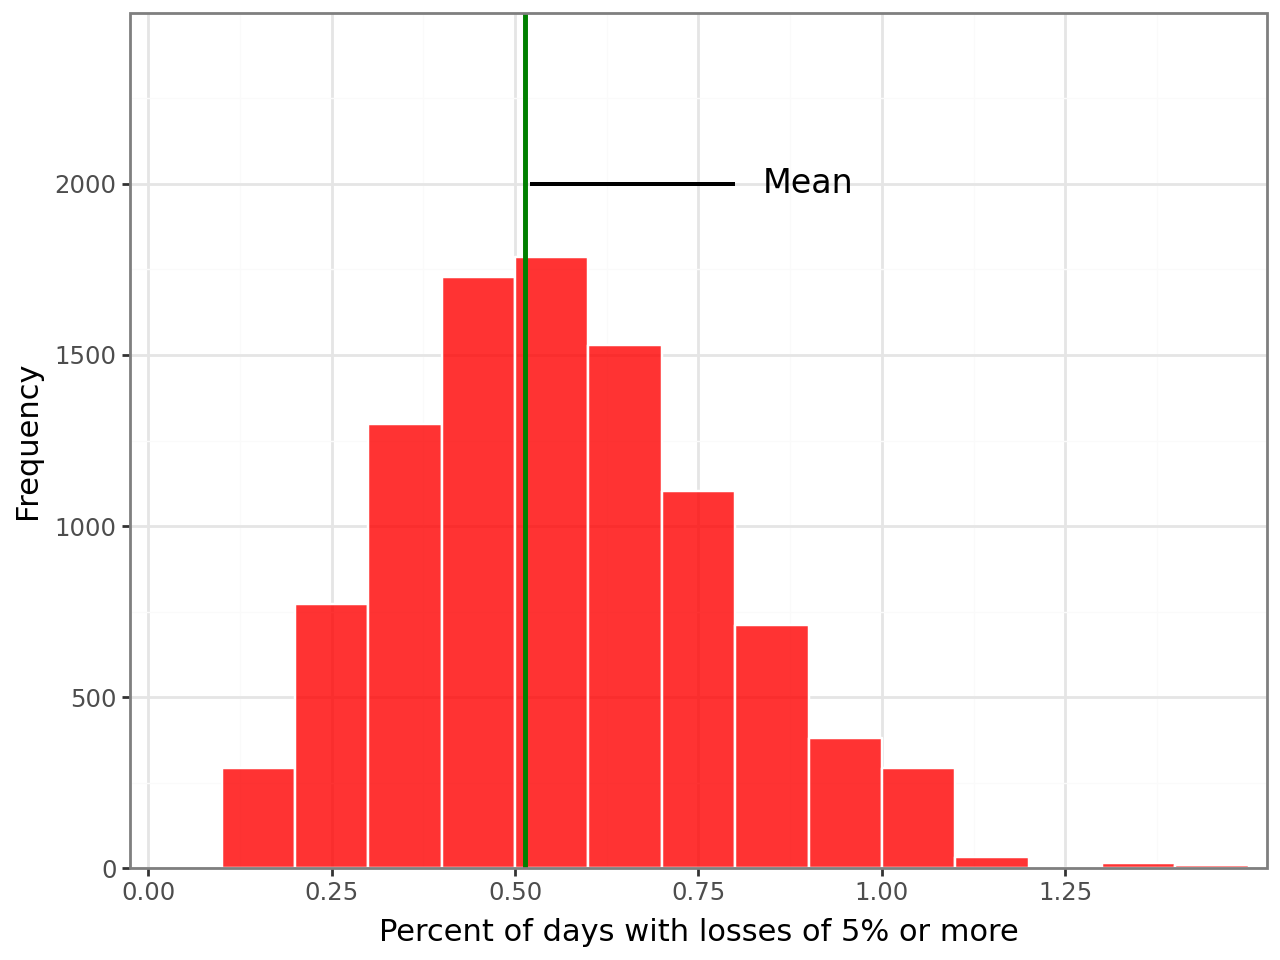

In [22]:
(
    ggplot(nobs_df, aes("nobs_1000"))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill="red",
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(aes(xintercept=nobs_df["nobs_1000"].mean()), color="green", size=1)
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=np.arange(0, 2500, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)

In [23]:
nobs_df["nobs_1000"].std()

np.float64(0.2240779529380329)

In [24]:
nobs_df["nobs_500"].std()

np.float64(0.32160267167398154)

In [25]:
nobs_df["nobs_1000"].mean()

np.float64(0.5141100000000001)

In [26]:
nobs_df["nobs_500"].mean()

np.float64(0.5173800000000001)

### Figure 5.3 

Not working with epanechnikov kernel

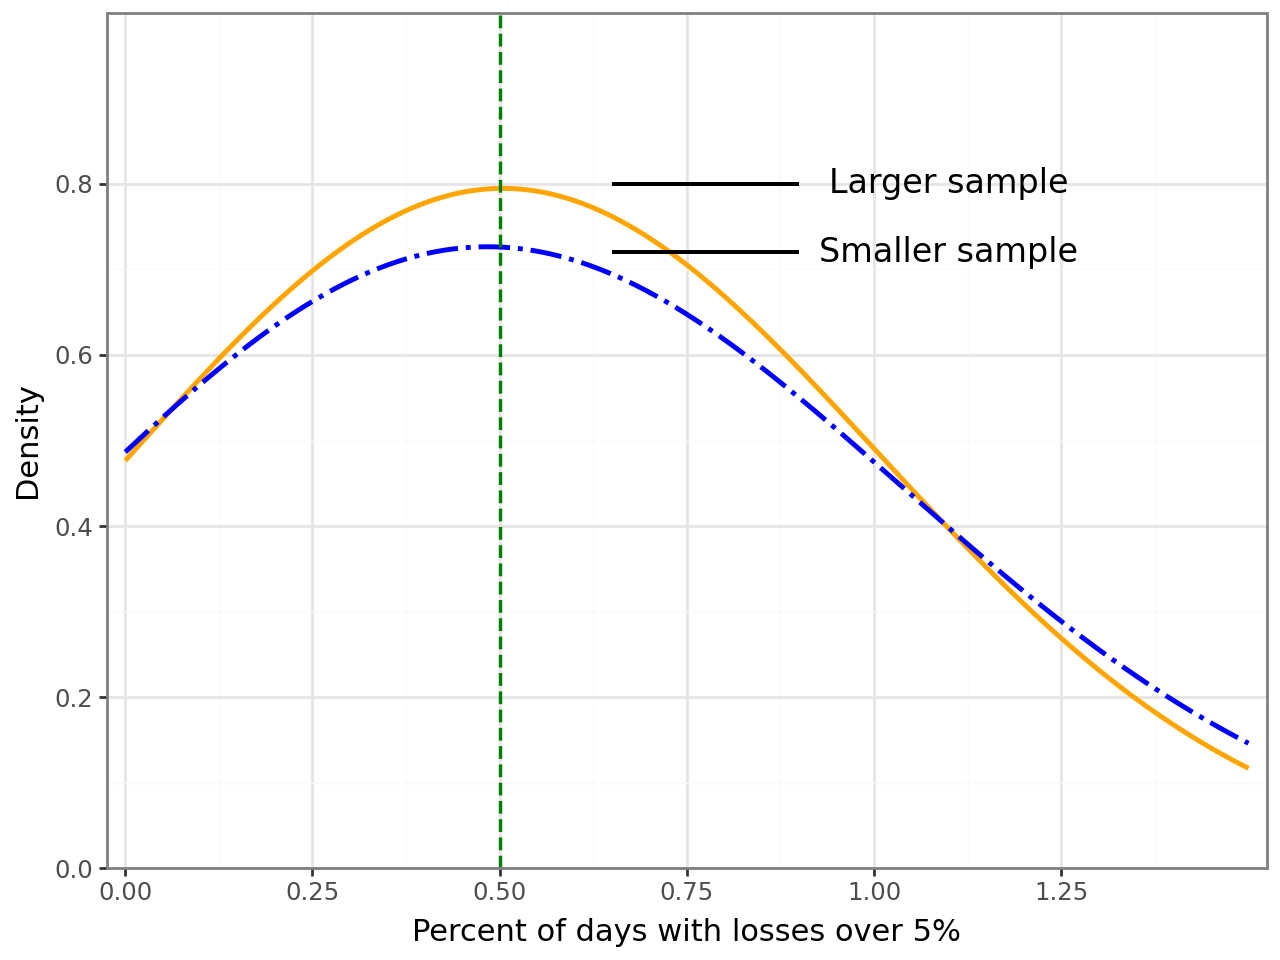

In [27]:
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color="orange", geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color="blue",
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color="green", size=0.7, linetype="dashed")
    + geom_segment(aes(x=0.9, y=0.8, xend=0.65, yend=0.8), size=0.5)
    + annotate("text", x=1.1, y=0.8, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5)
    + annotate("text", x=1.1, y=0.72, label="Smaller sample", size=12)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=np.arange(0, 1, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)

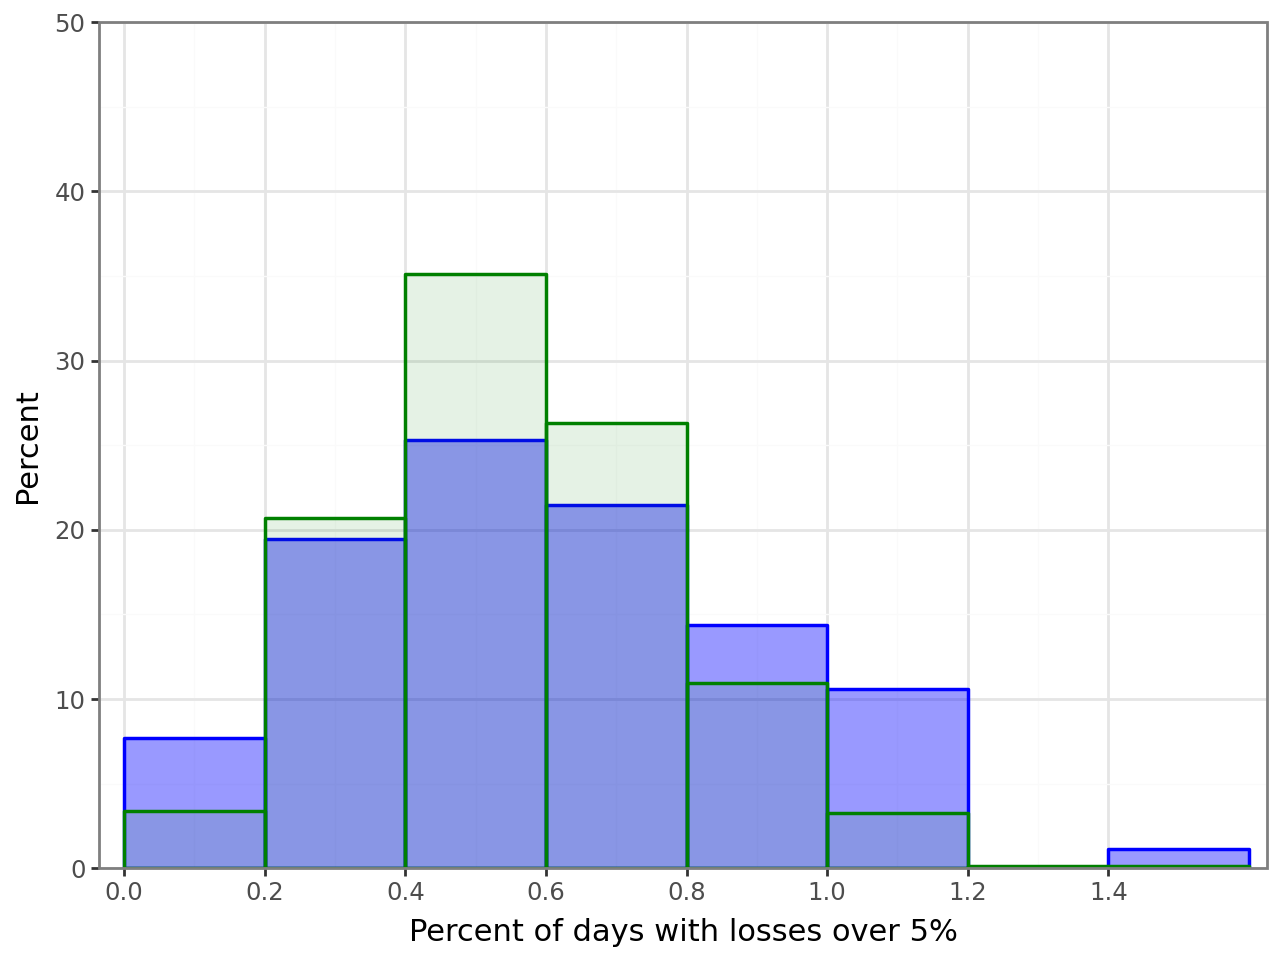

In [28]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color="blue",
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color="green",
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=np.arange(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=("blue", "green")
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


Create bootstrap samples

In [59]:
bootstrap_samples = np.random.choice(
    sp500["pct_return"].dropna(),
    size=(10000, len(sp500["pct_return"].dropna())),
    replace=True
)

In [60]:
pd.DataFrame(bootstrap_samples).T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.840751,-2.078329,1.800076,0.127550,0.614069,1.373952,0.215820,0.734577,0.116928,-1.504050,...,-0.445570,0.355289,0.021259,-0.252216,-0.093951,-0.324238,0.094654,1.055049,0.111283,-0.092894
1,0.550735,-1.264914,0.584346,-0.322810,0.485046,0.811413,0.992235,-0.005336,0.073980,-0.604538,...,0.690061,1.548661,0.080215,-1.428156,1.107890,-0.396539,-0.685159,1.187385,-0.136084,-0.202959
2,0.129566,-1.820361,-0.840389,0.278661,-0.274775,1.153139,-0.060609,0.221374,0.523029,-0.613166,...,-2.204067,0.377551,-0.199260,3.038918,0.900760,-0.164659,0.204345,-0.581306,-0.170418,-1.011567
3,-1.976940,-1.237467,0.759743,-1.443788,0.171698,-1.264914,4.250749,-0.527787,-0.420372,-0.886378,...,-0.632140,-0.321491,-0.721693,0.738456,-0.179889,-0.191311,1.532143,-1.743188,0.853481,-1.830202
4,-0.051669,0.004781,-0.982914,-0.588501,-1.372359,0.436192,-0.077849,0.703932,-0.478741,-1.245438,...,0.310587,-0.704794,-1.099575,-3.345989,-2.204067,1.364461,0.446911,1.201259,-0.632140,0.081776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,1.443947,0.400559,0.615227,-0.298546,3.649937,0.448111,1.738032,0.267313,-0.164437,2.192186,...,-4.459372,0.276919,0.321612,-1.616874,2.086137,-0.363561,-1.265320,1.800076,0.712659,-0.513026
2514,-0.259450,-0.097884,-1.679993,-1.491408,-0.474516,-0.862318,1.207547,0.634093,0.233789,0.369848,...,0.214991,1.126705,0.861606,0.293692,1.120019,-0.039005,0.618508,-2.078329,0.375240,-1.415388
2515,1.502440,-2.914451,0.422200,1.519015,0.702847,-0.280554,0.245933,-1.779724,1.440968,0.536711,...,0.299556,-0.260645,-0.244145,1.532143,-0.221330,0.724373,-0.166850,4.082583,-0.121747,2.429774
2516,0.759748,-0.216555,0.034830,0.712353,0.335440,0.080025,-2.936527,0.405142,1.189561,-0.588736,...,0.377551,-3.451124,0.068479,0.015581,6.472257,0.115847,-1.723346,-0.317966,1.708081,0.473457


Calculate percent of days wit losses over  thresholds from -1 to 10

In [61]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

In [62]:
bootstrap_loss_results

,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9,loss10
0,14.416203,5.321684,1.787133,1.032566,0.555997,0.397141,0.198570,0.198570,0.039714,0.0
1,14.575060,5.401112,1.787133,0.992851,0.754567,0.397141,0.238284,0.119142,0.000000,0.0
2,15.091342,4.725973,1.548848,0.714853,0.476569,0.238284,0.039714,0.039714,0.000000,0.0
3,14.773630,5.480540,2.581414,1.350278,0.516283,0.317712,0.119142,0.079428,0.039714,0.0
4,13.304210,4.567117,1.747419,0.992851,0.436855,0.277998,0.198570,0.079428,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,14.575060,5.281970,2.025417,0.833995,0.555997,0.317712,0.079428,0.039714,0.000000,0.0
9996,14.972200,5.361398,1.985703,1.072280,0.675139,0.555997,0.238284,0.198570,0.119142,0.0
9997,14.495631,4.884829,1.707705,0.953137,0.476569,0.277998,0.198570,0.158856,0.039714,0.0
9998,14.495631,5.837967,1.985703,1.151708,0.555997,0.476569,0.277998,0.198570,0.039714,0.0


Plot percent of days with losses over -5%

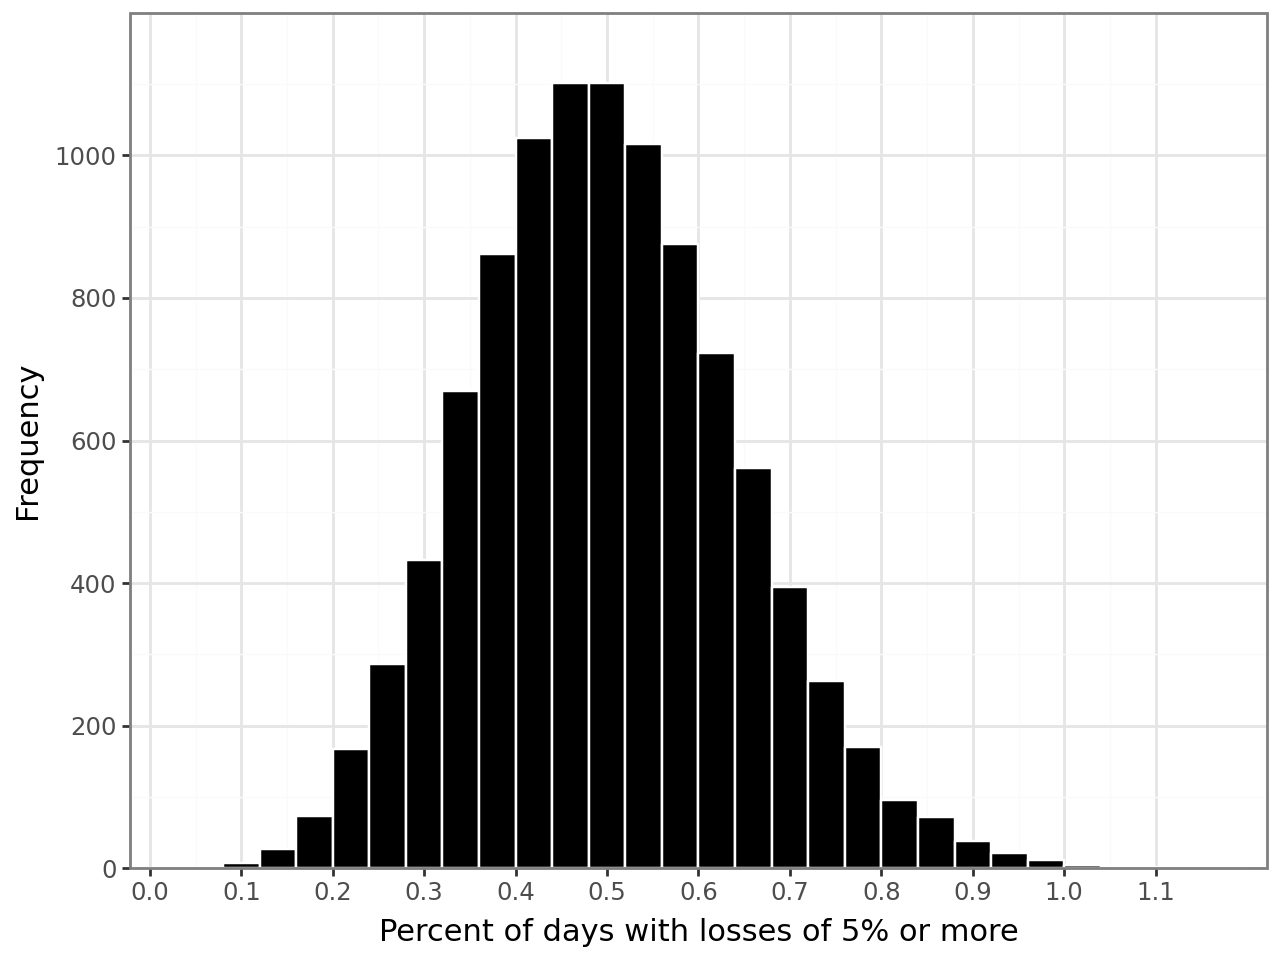

In [ ]:
(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill="black", color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=np.arange(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=np.arange(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)


In [66]:
bootstrap_loss_results["loss5"].std()

np.float64(0.14364358090586152)

In [ ]:
mean_loss5 = bootstrap_loss_results["loss5"].mean()
se_bootstrap = bootstrap_loss_results["loss5"].std()
ci_lower_se = mean_loss5 - 2 * se_bootstrap
ci_upper_se = mean_loss5 + 2 * se_bootstrap

print(f"Approximate 95% CI using SE*2: [{ci_lower_se:.4f}, {ci_upper_se:.4f}]")

Approximate 95% CI using SE*2: [0.2291, 0.8037]


In [37]:
# Assuming bootstrap_loss_results["loss5"] is a Series of bootstrap results
ci_lower = bootstrap_loss_results["loss5"].quantile(0.025)
ci_upper = bootstrap_loss_results["loss5"].quantile(0.975)

print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


95% Confidence Interval: [0.2383, 0.7943]


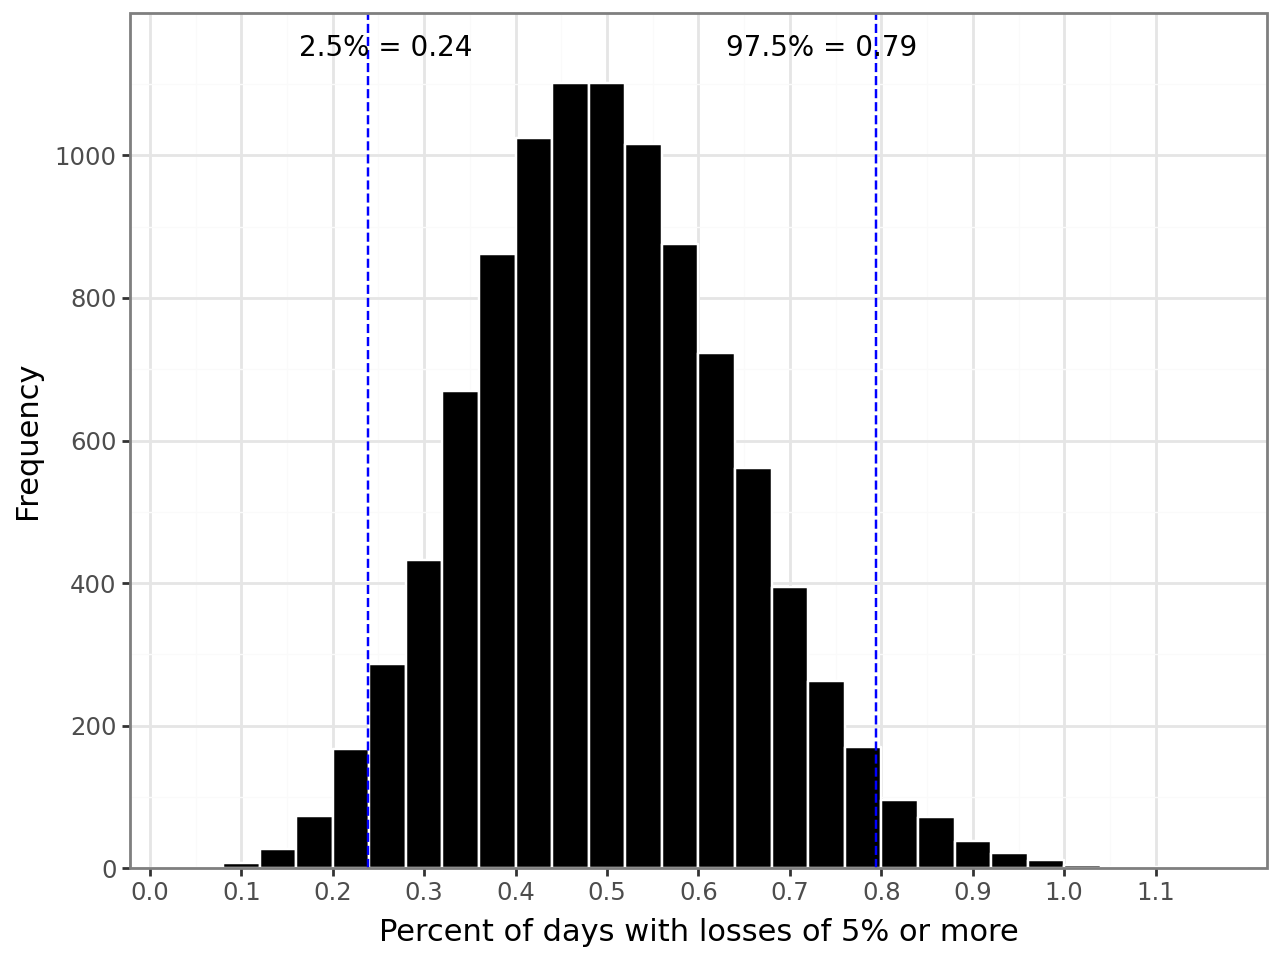

In [38]:
from plotnine import geom_vline, annotate

ci_lower = bootstrap_loss_results["loss5"].quantile(0.025)
ci_upper = bootstrap_loss_results["loss5"].quantile(0.975)

(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill="black", color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + geom_vline(xintercept=ci_lower, color="blue", linetype="dashed")
    + geom_vline(xintercept=ci_upper, color="blue", linetype="dashed")
    + annotate("text", x=ci_lower + 0.02, y=1150, label=f"2.5% = {ci_lower:.2f}", size=10)
    + annotate("text", x=ci_upper - 0.06, y=1150, label=f"97.5% = {ci_upper:.2f}", size=10)
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=np.arange(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=np.arange(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)


## Standard Error

In [45]:
sp500.count()

DATE          2519
VALUE         2519
pct_return    2518
year          2519
month         2519
yearmonth     2519
dtype: int64

In [51]:
ncov = round(1 / np.sqrt(sp500.count()),2)
ncov

DATE          0.02
VALUE         0.02
pct_return    0.02
year          0.02
month         0.02
yearmonth     0.02
dtype: float64

In [ ]:
# Calculate the indicator for loss > 5%
loss_indicator = (sp500["pct_return"] <= -5).dropna()
std_loss5 = loss_indicator.std(ddof=1)
print(f"Standard deviation of loss5 indicator: {std_loss5:.4f}")


Standard deviation of loss5 indicator: 0.0717


In [80]:
SE=std_loss5 *ncov
SE=SE*100
SE

DATE          0.143334
VALUE         0.143334
pct_return    0.143334
year          0.143334
month         0.143334
yearmonth     0.143334
dtype: float64

### Compare with we got from bootstrap

In [44]:
std_loss5 = bootstrap_loss_results["loss5"].std()
print(f"Standard deviation of fraction of 5%+ loss: {std_loss5}")

Standard deviation of fraction of 5%+ loss: 0.14308943778595506


### And just to calc a Confidence Interval for original dataset sp500

In [105]:
from scipy.stats import norm

mean_loss5_or = loss_indicator.mean()
std_loss5_or = loss_indicator.std(ddof=1)
n = loss_indicator.count()
se = std_loss5_or / np.sqrt(n)
z = norm.ppf(0.975)  # 1.96 for 95% CI

ci_lower =round((mean_loss5_or - z * se)*100,1)
ci_upper =round((mean_loss5_or + z * se)*100,1)

print(f"95% Confidence Interval: [{ci_lower:.1f}, {ci_upper:.1f}]")


95% Confidence Interval: [0.2, 0.8]


In [88]:
std_loss5.std()

np.float64(0.0)